# Урок 4. CNN Свертки

Обучите CNN (самописная) на CIFAR-100.<br>

Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.<br>

\*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 240)
        self.fc2 = torch.nn.Linear(240, 120)
        self.out = torch.nn.Linear(120, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net()
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=100, bias=True)
)


In [4]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [5]:
num_ep = 12

In [6]:
all_manual = {}

for epoch in tqdm(range(num_ep)):  
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = net(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
    all_manual[epoch] = loss_accumed

print('Training is finished!')

  8%|▊         | 1/12 [01:12<13:16, 72.41s/it]

Epoch 0 valid_loss 80.08786010742188


 17%|█▋        | 2/12 [02:17<11:18, 67.81s/it]

Epoch 1 valid_loss 76.87605285644531


 25%|██▌       | 3/12 [03:20<09:53, 65.98s/it]

Epoch 2 valid_loss 76.63804626464844


 33%|███▎      | 4/12 [04:25<08:42, 65.32s/it]

Epoch 3 valid_loss 77.3251724243164


 42%|████▏     | 5/12 [05:29<07:33, 64.84s/it]

Epoch 4 valid_loss 74.95658874511719


 50%|█████     | 6/12 [06:34<06:29, 64.99s/it]

Epoch 5 valid_loss 72.50885009765625


 58%|█████▊    | 7/12 [07:40<05:27, 65.43s/it]

Epoch 6 valid_loss 79.11381530761719


 67%|██████▋   | 8/12 [08:46<04:21, 65.40s/it]

Epoch 7 valid_loss 71.67729187011719


 75%|███████▌  | 9/12 [09:51<03:16, 65.38s/it]

Epoch 8 valid_loss 68.48345947265625


 83%|████████▎ | 10/12 [10:56<02:10, 65.27s/it]

Epoch 9 valid_loss 68.37760162353516


 92%|█████████▏| 11/12 [11:57<01:03, 63.96s/it]

Epoch 10 valid_loss 69.35382843017578


100%|██████████| 12/12 [12:57<00:00, 64.81s/it]

Epoch 11 valid_loss 70.38447570800781
Training is finished!


### Предобученные модели

In [7]:
from torchvision import models
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 1000)

In [10]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
params_to_update

[Parameter containing:
 tensor([[-8.3911e-03,  2.1450e-02, -1.7014e-02,  ..., -1.5881e-02,
          -1.8910e-02, -1.7512e-02],
         [ 1.9355e-02, -4.0247e-03,  4.3525e-03,  ..., -1.7729e-02,
          -5.5280e-03,  2.1757e-02],
         [-9.2769e-03,  7.6716e-03, -3.9116e-03,  ..., -2.0470e-02,
           1.2663e-02, -6.0461e-03],
         ...,
         [ 3.1582e-04, -1.5644e-02,  1.4794e-02,  ...,  7.8737e-03,
           7.8649e-05,  1.9739e-02],
         [-3.0096e-03,  1.1927e-02, -1.6045e-02,  ..., -2.1253e-02,
          -6.1299e-03,  8.1439e-03],
         [-1.6570e-02,  1.0922e-02, -9.8642e-03,  ...,  1.1483e-02,
          -1.9068e-02,  1.9435e-02]], requires_grad=True),
 Parameter containing:
 tensor([-1.9870e-02, -1.6219e-03, -1.1566e-02,  5.8014e-03,  4.8090e-03,
         -8.6859e-03,  2.1433e-02,  4.9149e-03, -4.0822e-03, -1.5951e-02,
          1.0794e-02,  9.5603e-03,  3.1023e-03, -2.2326e-03, -1.7067e-02,
         -2.0614e-02,  9.3399e-03, -1.4554e-02,  1.5760e-02, -8.38

In [12]:
all_pretrained = {}

for epoch in tqdm(range(num_ep)):  
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = resnet50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
    all_pretrained[epoch] = loss_accumed

print('Training is finished!')

  8%|▊         | 1/12 [04:57<54:31, 297.38s/it]

Epoch 0 valid_loss 74.91597747802734


 17%|█▋        | 2/12 [09:59<50:00, 300.01s/it]

Epoch 1 valid_loss 72.29035949707031


 25%|██▌       | 3/12 [15:04<45:22, 302.49s/it]

Epoch 2 valid_loss 71.57561492919922


 33%|███▎      | 4/12 [20:16<40:48, 306.07s/it]

Epoch 3 valid_loss 72.31021881103516


 42%|████▏     | 5/12 [25:20<35:37, 305.36s/it]

Epoch 4 valid_loss 72.3897476196289


 50%|█████     | 6/12 [30:22<30:25, 304.28s/it]

Epoch 5 valid_loss 72.30049896240234


 58%|█████▊    | 7/12 [35:19<25:08, 301.77s/it]

Epoch 6 valid_loss 69.35945892333984


 67%|██████▋   | 8/12 [40:21<20:08, 302.01s/it]

Epoch 7 valid_loss 73.20992279052734


 75%|███████▌  | 9/12 [45:23<15:05, 301.84s/it]

Epoch 8 valid_loss 71.05926513671875


 83%|████████▎ | 10/12 [50:24<10:03, 301.62s/it]

Epoch 9 valid_loss 70.12828826904297


 92%|█████████▏| 11/12 [55:25<05:01, 301.56s/it]

Epoch 10 valid_loss 70.57279205322266


100%|██████████| 12/12 [1:00:27<00:00, 302.28s/it]

Epoch 11 valid_loss 71.41283416748047
Training is finished!


In [13]:
import matplotlib.pyplot as plt

In [14]:
print([i for i in all_manual.keys()])
print([i.tolist() for i in all_manual.values()])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[80.08786010742188, 76.87605285644531, 76.63804626464844, 77.3251724243164, 74.95658874511719, 72.50885009765625, 79.11381530761719, 71.67729187011719, 68.48345947265625, 68.37760162353516, 69.35382843017578, 70.38447570800781]


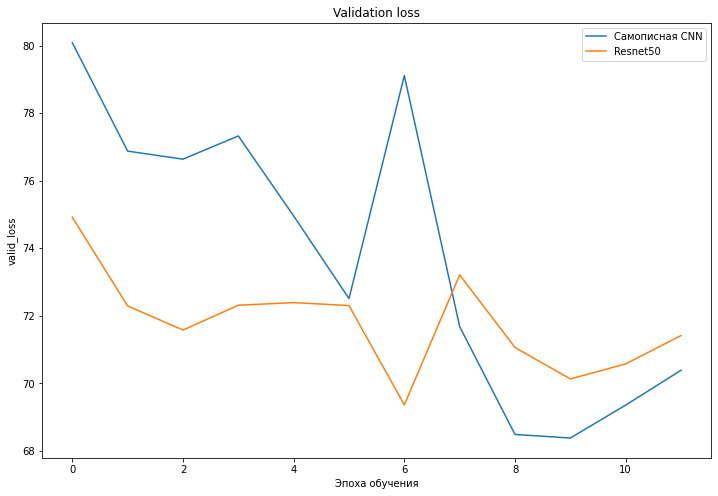

In [15]:
fig = plt.figure(figsize=(12,8))
plt.plot([i for i in all_manual.keys()], [i.tolist() for i in all_manual.values()], label='Самописная CNN')
plt.plot([i for i in all_pretrained.keys()], [i.tolist() for i in all_pretrained.values()], label='Resnet50')
plt.title('Validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('valid_loss')
plt.legend()
plt.show()